# Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Loading the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [3]:
# Check the structure of the data after it's loaded

print("Shape of the demographics data file for the general population: {}".format(azdias.shape))
print("Shape of the features file: {}".format(feat_info.shape))

print("\nPrint a sample of the feature file:\n{}".format(feat_info.head(5)))
print("\nPrint unique values in the missing_or_unknown column:")
print(feat_info['missing_or_unknown'].unique())
print("\nPrint a sample of the data file")
azdias.head(5)

Shape of the demographics data file for the general population: (891221, 85)
Shape of the features file: (85, 4)

Print a sample of the feature file:
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

Print unique values in the missing_or_unknown column:
['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']

Print a sample of the data file


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to  make cleaning decisions during this stage of the project.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I will parse it to make use of it to identify and clean the data. I will convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [11]:
# Identify naturally occuring missing values
print("10 features having the highest number of naturally missing values")
print(azdias.isnull().sum().sort_values(0,ascending=False).head(10))

10 features having the highest number of naturally missing values
KK_KUNDENTYP    584612
KBA05_ANTG1     133324
KBA05_ANTG2     133324
KBA05_ANTG3     133324
KBA05_ANTG4     133324
KBA05_BAUMAX    133324
KBA05_GBZ       133324
MOBI_REGIO      133324
REGIOTYP        121196
KKK             121196
dtype: int64


In [3]:
# Identify missing or unknown data values and convert them to NaNs.

def convert_missing_nan(data):
    for i in range(len(feat_info)):
        col_i_feat3 = feat_info.iloc[i,3] 
        # Get the missing/unknown string value for column i from feature info 
        col_i_feat3_list = str(col_i_feat3)[1:-1].split(',')#re.findall("\-?\w",col_i_feat3) 
        # Convert the missing/unknown string value to a list
        data.iloc[:,i][data.iloc[:,i].isin(col_i_feat3_list)] = np.nan 
        # If data for the column i matches the list, convert to numpy nan
    return(data)

azdias = convert_missing_nan(azdias) # convert missing values in azdias data to nan
        
azdias.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
# Feature has different number of unique values between the general population and customer 
print(azdias['GEBAEUDETYP'].unique())
print(customers['GEBAEUDETYP'].unique())

[ nan   8.   1.   3.   2.   6.   4.   5.]
[  1.  nan   8.   2.   3.   4.   6.]


In [4]:
# Need to remove 'GEBAEUDETYP' because it has different number of unique values in demographic data
# and the customer data causing one hot encoding to create different no of columns
azdias = azdias.drop(labels='GEBAEUDETYP',axis=1)
feat_info = feat_info[feat_info['attribute']!='GEBAEUDETYP']

#### Step 1.1.2: Assess Missing Data in Each Column

Now I will identify a few columns that are outliers in terms of the proportion of values that are missing. And take a call to remove if a column is missing values beyond a threshold.

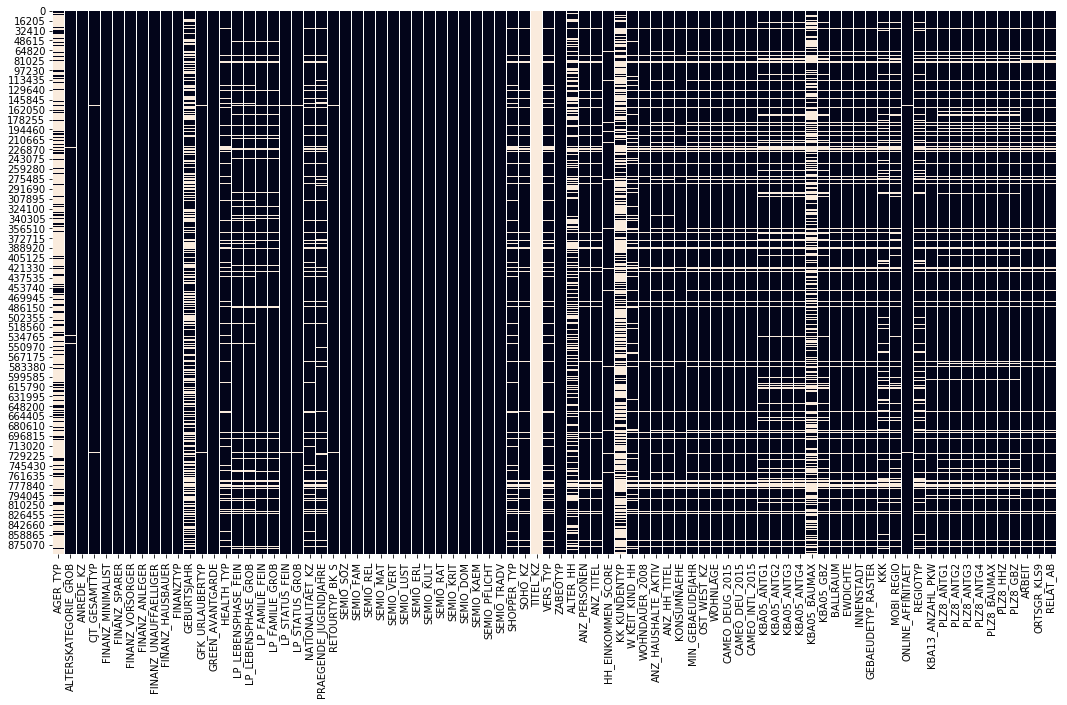

In [17]:
# Heatmap to show the frequency and distribution of nan values
# Comment if the heatmap takes a long time

plt.figure(figsize=(18,10))
sns.heatmap(azdias.isnull(), cbar=False)

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nrow, ncol = azdias.shape

def find_outliers_nan(data,ax,threshold,data_count):
    sorted_by_nan = data.isnull().sum(axis=ax).sort_values(0,ascending=False).reset_index()
    sorted_by_nan_renamed = sorted_by_nan.rename(columns={sorted_by_nan.columns[0]: "Feature/Index", sorted_by_nan.columns[1]: "Nan Count" })
    sorted_by_nan_renamed['Nan Percentage'] = sorted_by_nan_renamed['Nan Count']*100/data_count
    return(sorted_by_nan_renamed[sorted_by_nan_renamed['Nan Percentage']>threshold])
    
col_outliers_nan = find_outliers_nan(azdias,0,33,nrow)
col_outliers_nan

,Feature/Index,Nan Count,Nan Percentage
0,TITEL_KZ,889061,99.757636
1,AGER_TYP,685843,76.955435
2,KK_KUNDENTYP,584612,65.596749
3,KBA05_BAUMAX,476524,53.468668
4,GEBURTSJAHR,392318,44.020282
5,ALTER_HH,310267,34.813699


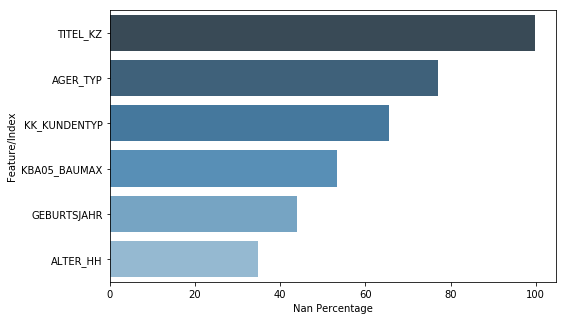

In [19]:
plt.figure(figsize=(8,5))
sns.barplot(y='Feature/Index',x='Nan Percentage',data=col_outliers_nan,palette="Blues_d")

In [21]:
# Investigate patterns in the amount of missing data in each column.

pd.merge(col_outliers_nan,feat_info,left_on='Feature/Index',right_on='attribute',how='left')

,Feature/Index,Nan Count,Nan Percentage,attribute,information_level,type,missing_or_unknown
0,TITEL_KZ,889061,99.757636,TITEL_KZ,person,categorical,"[-1,0]"
1,AGER_TYP,685843,76.955435,AGER_TYP,person,categorical,"[-1,0]"
2,KK_KUNDENTYP,584612,65.596749,KK_KUNDENTYP,household,categorical,[-1]
3,KBA05_BAUMAX,476524,53.468668,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
4,GEBURTSJAHR,392318,44.020282,GEBURTSJAHR,person,numeric,[0]
5,ALTER_HH,310267,34.813699,ALTER_HH,household,interval,[0]


In [6]:
# Remove the outlier columns from the dataset
# Azdiaz minus the outlier columns

azdias_less_out_col = azdias.drop(labels=col_outliers_nan['Feature/Index'].values,axis=1)
azdias_less_out_col.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Observations about columns missing data

* There are quite a few columns having large numbers of naturally missing values
* After converting all missing/unknown values to nan, there are 6 outliers (more than 30% values are nan)
* Top 3 columns with the highest missing value percentage are all categorical variables
* Out the columns removed as outliers due to missing values:
    - TITEL_KZ: More than 99% values are missing, hence removed
    - AGER_TYP: Culturally experienced/passive elderly etc, can be substituted with age
    - KBA05_BAUMAX: Most common building type in a microcell, can be substituted with other indicators
    - GEBURTSJAHR: Year of birth, can be substituted with age
    - ALTER_HH: Birthdate, can be substituted with age

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I will perform a similar assessment for the rows of the dataset. I will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I will check if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I will compare the distribution of values for at least 5 such columns.

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then I will make a note on those data as special.

In [7]:
# How much data is missing in each row of the dataset?

row_outliers_nan = find_outliers_nan(azdias_less_out_col,1,50,ncol)
print("Percentage of rows marked as outliers: {}".format(len(row_outliers_nan)*100/nrow))
row_outliers_nan.tail()

Percentage of rows marked as outliers: 5.187265560394111


,Feature/Index,Nan Count,Nan Percentage
46225,713399,43,51.190476
46226,873920,43,51.190476
46227,15328,43,51.190476
46228,109445,43,51.190476
46229,466843,43,51.190476


In [8]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

print("Number of rows before dropping: {}".format(len(azdias_less_out_col)))
azdias_regular = azdias_less_out_col.drop(labels=row_outliers_nan['Feature/Index'],axis=0)
print("Number of rows before dropping: {}".format(len(azdias_regular)))
azdias_outliers = azdias_less_out_col.iloc[row_outliers_nan['Feature/Index'].values,:]
print("Outlier data set length: {}".format(len(azdias_outliers)))

Number of rows before dropping: 891221
Number of rows before dropping: 844991
Outlier data set length: 46230


Percent missing values in the data set with minimum outliers
ALTERSKATEGORIE_GROB    0.340950
FINANZTYP               0.000000
ONLINE_AFFINITAET       0.565095
LP_STATUS_FEIN          0.565095
HH_EINKOMMEN_SCORE      2.162035
dtype: float64

Percent missing values in the data set with more outliers
ALTERSKATEGORIE_GROB    0.000000
FINANZTYP               0.000000
ONLINE_AFFINITAET       0.170885
LP_STATUS_FEIN          0.170885
HH_EINKOMMEN_SCORE      0.170885
dtype: float64


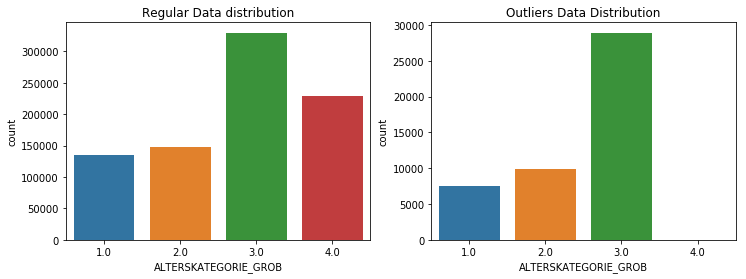

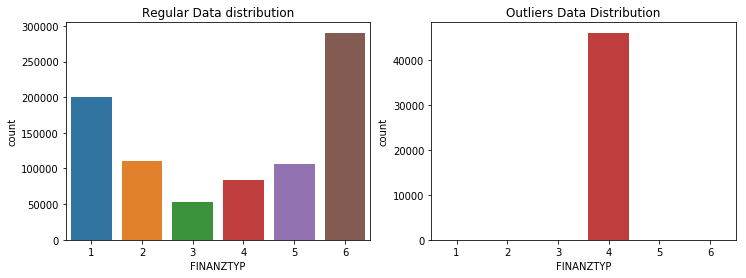

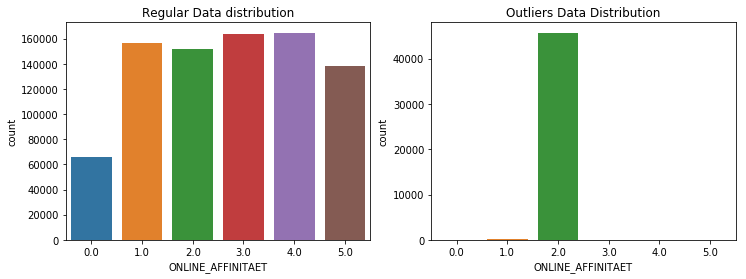

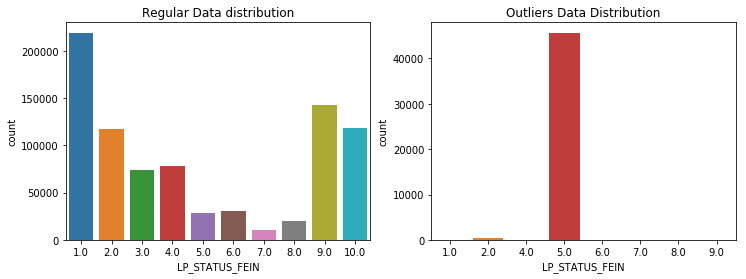

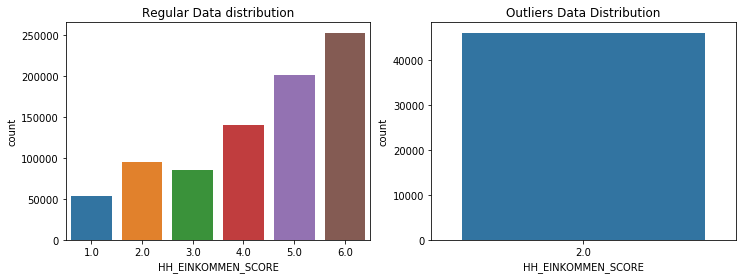

In [9]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


dist_features = ['ALTERSKATEGORIE_GROB','FINANZTYP','ONLINE_AFFINITAET','LP_STATUS_FEIN','HH_EINKOMMEN_SCORE']
print("Percent missing values in the data set with minimum outliers")
print(azdias_regular[dist_features].isnull().sum()*100/len(azdias_regular))
print("\nPercent missing values in the data set with more outliers")
print(azdias_outliers[dist_features].isnull().sum()*100/len(azdias_outliers))


for feature in dist_features:
    f, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.countplot(x=feature, data=azdias_regular, ax = axes[0])
    axes[0].set_title("Regular Data distribution")
    sns.countplot(x=feature, data=azdias_outliers, ax = axes[1])
    axes[1].set_title("Outliers Data Distribution")

#### Observations about rows missing data

* For the 5 columns analyzed, the distribution of data between the two datasets look different
    - ALTERSKATEGORIE_GROB: One of the codes (4 - Age > 60 years) is not at all available in the outlier data set
    - FINANZTYP: The outlier data set has only one code (4 - Be prepared financially)
    - ONLINE_AFFINITAET: Code 2 (middle online affinity) dominates the outlier data set
    - LP_STATUS_FEIN: For social status, minimalist high income earners (5) dominate the outlier set while regular data has a lot of typical low income earners (1) 
    - HH_EINKOMMEN_SCORE: Estimated household income in the outlier data set only contains very high income group (2)
    
* The outliers seem to have a lot of high income households

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I will make a few encoding changes. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. The third column of the feature summary (`feat_info`) shows the summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

Imputing choices:
* For ordinal and categorical features, I imputed the missing values with the most frequently occuring value
* For numerical features, I imputed with the median

In [26]:
# How many features are there of each data type?

feat_info.groupby('type')['type'].count()

type
categorical    20
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

- For binary (two-level) categoricals that take numeric values, I will keep them as is.
- For binary variable that takes on non-numeric values, I will re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I will encode the values using multiple dummy variables

In [10]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def cat_feat_investigation(feat_info,col_outliers_nan,df):
    feat_less_outliers = feat_info[~feat_info['attribute'].isin(col_outliers_nan['Feature/Index'].values)] #Remove outlier columns from feat_info
    cat_feat = feat_less_outliers[feat_less_outliers['type']=='categorical']['attribute'] # Get categorical features

    multi_level_cat = []
    binary_cat = []

    for feature in df[cat_feat]:
        print("Feature: {} , Unique values: {}".format(feature,df[feature].unique()))
        if df[feature].nunique() > 2: #create a list of list of multi-level variables
            multi_level_cat.append(feature)
        else:
            binary_cat.append(feature)            #create a list of binary variables

    #Remove CAMEO_DEU_2015 as it contains a very large number of unique values and causes issue with sklearn one hot encoding
    multi_level_cat.remove('CAMEO_DEU_2015')
    cat_feat = cat_feat[cat_feat.iloc[:]!='CAMEO_DEU_2015']
    return(multi_level_cat,cat_feat,binary_cat,feat_less_outliers)
    
multi_level_cat,cat_feat,binary_cat,feat_less_outliers = cat_feat_investigation(feat_info,col_outliers_nan,azdias_regular)

Feature: ANREDE_KZ , Unique values: [1 2]
Feature: CJT_GESAMTTYP , Unique values: [  2.   5.   3.   4.   1.   6.  nan]
Feature: FINANZTYP , Unique values: [4 1 6 5 2 3]
Feature: GFK_URLAUBERTYP , Unique values: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Feature: GREEN_AVANTGARDE , Unique values: [0 1]
Feature: LP_FAMILIE_FEIN , Unique values: [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
Feature: LP_FAMILIE_GROB , Unique values: [  2.   3.   1.  nan   5.   4.]
Feature: LP_STATUS_FEIN , Unique values: [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
Feature: LP_STATUS_GROB , Unique values: [  1.   2.   4.   5.   3.  nan]
Feature: NATIONALITAET_KZ , Unique values: [ nan   1.   3.   2.]
Feature: SHOPPER_TYP , Unique values: [ nan   3.   2.   1.   0.]
Feature: SOHO_KZ , Unique values: [ nan   1.   0.]
Feature: VERS_TYP , Unique values: [ nan   2.   1.]
Feature: ZABEOTYP , Unique values: [3 5 4 1 6 2]
Feature: OST_WEST_KZ , Unique values: [nan

In [11]:
# Impute and Encode categorical features

def impute_and_encode(df,cat_feat,multi_level_cat):
    # Encode 'OST_WEST_KZ' from strings to numbers
    df_imputed = df.copy()

    le = LabelEncoder()
    df_imputed['OST_WEST_KZ'] = le.fit_transform(df['OST_WEST_KZ'].astype(str))

    #Impute most frequent values for categorical variables
    imp_cat = Imputer(missing_values=np.nan,strategy='most_frequent')
    df_imputed[cat_feat] = imp_cat.fit_transform(df_imputed[cat_feat])

    # Re-encode categorical variable(s) to be kept in the analysis.
    df_encoded = pd.DataFrame()
    df_encoded = pd.get_dummies(df[multi_level_cat].astype(str),drop_first=True)
    return(df_imputed,df_encoded)

azdias_imputed,azdias_encoded = impute_and_encode(azdias_regular,cat_feat,multi_level_cat)

azdias_encoded.head()

,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,...,ZABEOTYP_6,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


#### Summary - encoding categorical variables:

* Dropped CAMEO_DEU_2015, as it contained too many categories
* Used label encoder to convert OST_WEST_KZ from string to numeric binary variable
* Imputed the categorical variables with the most frequently occuring value
* One hot encoded the multi level categorical variables

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis

In [29]:
# Check all mixed features
feat_less_outliers[feat_less_outliers['type']=='mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

Percentage of missing values in PRAEGENDE_JUGENDJAHRE:
7.33534440012


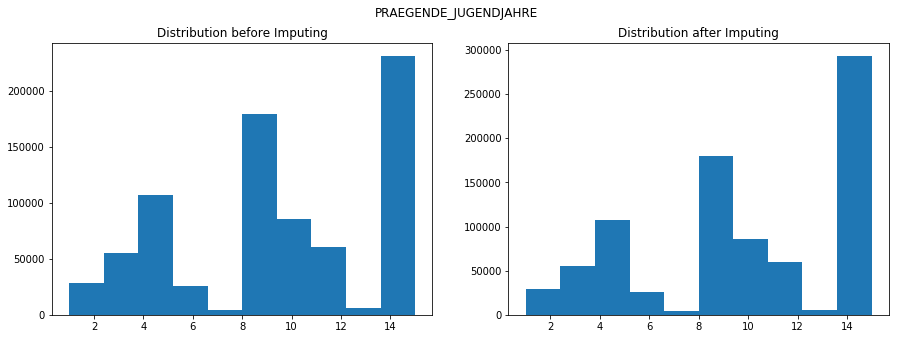

Percentage of missing values in CAMEO_INTL_2015:
6.28669417781


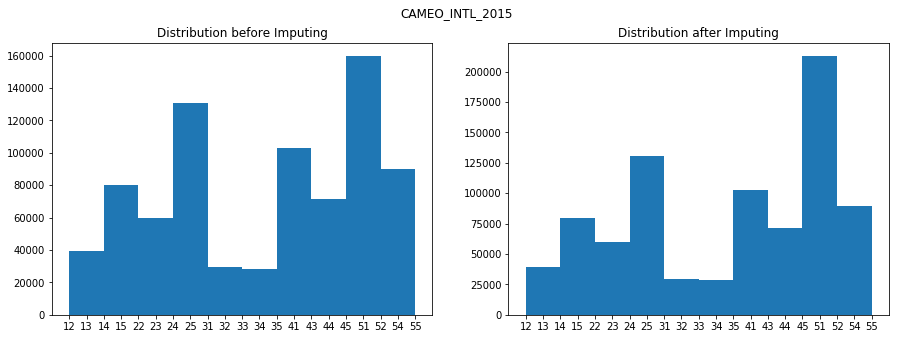

Percentage of missing values in PLZ8_BAUMAX:
8.31784007167


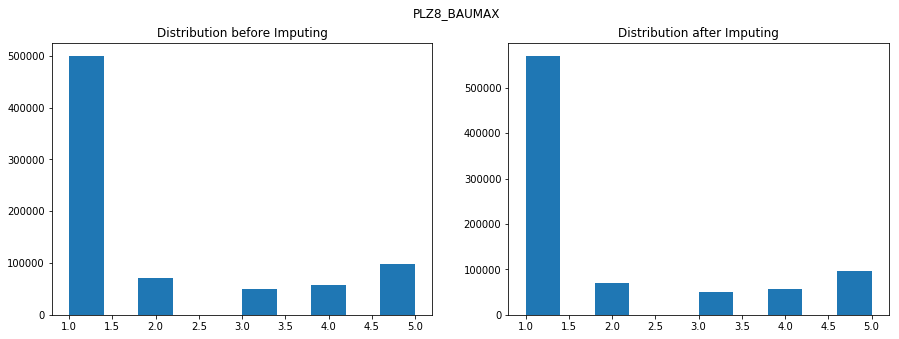

In [13]:
# Investigate "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015" and PLZ8_BAUMAX for missing values

mixed = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','PLZ8_BAUMAX']

# Percentage and distribution of missing values
def mixed_feature_investigation(df,df_imputed,feature_name):
    print("Percentage of missing values in {}:".format(feature_name))
    print(df[feature_name].isnull().sum()*100/len(df))

    #Impute missing values with the most frequent values
    df_imputed[feature_name] = df[feature_name].fillna(df[feature_name].mode().iloc[0])
    
    # Show before and after distributions
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    ax[0].hist(df[feature_name].dropna())
    ax[1].hist(df_imputed[feature_name])
    # Add titles
    ax[0].set_title("Distribution before Imputing")
    ax[1].set_title("Distribution after Imputing")
    plt.suptitle("{}".format(feature_name))
    plt.show()
    return(df_imputed)

def all_mixed_investigation(df,df_imputed,feature):
    for feature in mixed:
        df_imputed = mixed_feature_investigation(df,df_imputed,feature)
    return(df_imputed)
        
azdias_imputed = all_mixed_investigation(azdias_regular,azdias_imputed,feature)

In [14]:
# # Engineer new features from the mixed features

#Create a dictionary for called PRAEGENDE_JUGENDJAHRE (Mainstream = 1, Avantgarde = 0)
PRAEGENDE_JUGENDJAHRE = {"1": [40,1], "2": [40,0], "3": [50,1], "4": [50,0],\
                         "5": [60,1], "6": [60,0], "7": [60,0], "8": [70,1],\
                         "9": [70,0], "10": [80,1], "11": [80,0], "12": [80,1],\
                         "13": [80,0], "14": [90,1], "15": [90,0]}


def eng_new_feat(df_imputed,df_encoded):
    new_feat = ['DECADE','MOVEMENT','WEALTH','LIFE_STAGE','PLZ8_BAUMAX_TYPE','WOHNLAGE']
    
    #Engineer new features
    df_encoded['DECADE'] = df_imputed['PRAEGENDE_JUGENDJAHRE'].astype(int).astype(str).map(lambda x: PRAEGENDE_JUGENDJAHRE[x][0])
    df_encoded['MOVEMENT'] = df_imputed['PRAEGENDE_JUGENDJAHRE'].astype(int).astype(str).map(lambda x: PRAEGENDE_JUGENDJAHRE[x][1])
    df_encoded['WEALTH'] = df_imputed['CAMEO_INTL_2015'].astype(str).str[0].astype(int)
    df_encoded['LIFE_STAGE'] = df_imputed['CAMEO_INTL_2015'].astype(str).str[1].astype(int)
    df_encoded['PLZ8_BAUMAX_TYPE'] = df_imputed['PLZ8_BAUMAX'].replace(to_replace=[1.0,2.0,3.0,4.0],value=1)
    df_encoded['PLZ8_BAUMAX_TYPE'] = df_imputed['PLZ8_BAUMAX'].replace(to_replace=5.0,value=0)
    df_encoded['WOHNLAGE'] = df_imputed['WOHNLAGE'].replace(to_replace=8.0, value=7.0)
    
    # Impute missing values with the most frequent value for the new features
    imp_new = Imputer(missing_values = np.nan, strategy='most_frequent')
    df_encoded[new_feat] = imp_new.fit_transform(df_encoded[new_feat])
    
    return(df_encoded)

azdias_encoded = eng_new_feat(azdias_imputed,azdias_encoded)

#### Summary: Engineering Mixed-Type Features

* Engineered new features, decade and movement from PRAEGENDE_JUGENDJAHRE
* Engineered new features, wealth and life stage from CAMEO_INTL_2015
* LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB contain information (income,family) already available in other features, can be dropped
* WOHNLAGE - except for one value (8), this is not really a mixed attribute. Changes 8 to 7, so that this becomes a ordinal variable
* PLZ8_BAUMAX, engineered a new binary variable, business building (0) or family home (1)

#### Step 1.2.3: Complete Feature Selection

Now I will include only the below columns in the final data set:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

For the new columns that I engineered, I have excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project.

In [16]:
# Create final dataframe

print("Types of features:")
print(feat_info.groupby('type')['type'].count())

def create_final_df(df_imputed,df_encoded,feat_less_outliers,binary_cat):
    #Find ordinal and numerical features
    ord_feat = feat_less_outliers[feat_less_outliers['type'].isin(['ordinal'])]['attribute'].values
    num_feat = feat_less_outliers[feat_less_outliers['type'].isin(['numeric'])]['attribute'].values
    # Initialize imputer
    imp_ord = Imputer(missing_values=np.nan,strategy='most_frequent')
    imp_num = Imputer(missing_values=np.nan,strategy='median')
    # Fit and transform imputer for ordinal and numerical features
    df_imputed[ord_feat] = imp_ord.fit_transform(df_imputed[ord_feat])
    df_imputed[num_feat] = imp_num.fit_transform(df_imputed[num_feat])
    df_encoded = df_encoded.assign(**df_imputed[ord_feat])
    df_encoded = df_encoded.assign(**df_imputed[num_feat])
    #Include binary categorical features
    df_encoded = df_encoded.assign(**df_imputed[binary_cat])
    print("\nShape of the dataframe: {}".format(df_encoded.shape))
    return(df_encoded)
    
azdias_encoded = create_final_df(azdias_imputed,azdias_encoded,feat_less_outliers,binary_cat)

Types of features:
type
categorical    20
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

Shape of the dataframe: (844991, 141)


### Step 1.3: Create a Cleaning Function

I will need to perform the same cleaning steps I applied on the general population, again on the customer demographics data. In this substep, I will create a function to execute the main feature selection, encoding, and re-engineering steps I performed above, which can be used with the customer demographics data.

In [17]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    nrows, ncols = df.shape
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = convert_missing_nan(df)
    
    # remove selected columns and rows, ...
    col_outliers_nan = find_outliers_nan(df,0,33,nrows)
    df_less_out_col = df.drop(labels=col_outliers_nan['Feature/Index'].values,axis=1)   
    row_outliers_nan = find_outliers_nan(df_less_out_col,1,50,ncols)
    df_regular = df_less_out_col.drop(labels=row_outliers_nan['Feature/Index'],axis=0)
    
    # select, re-encode, and engineer column values.
    # Encode categorical features
    multi_level_cat,cat_feat,binary_cat,feat_less_outliers = cat_feat_investigation(feat_info,col_outliers_nan,df_regular)
    df_imputed,df_encoded = impute_and_encode(df_regular,cat_feat,multi_level_cat)

    # Encode mixed features
    df_imputed = all_mixed_investigation(df_regular,df_imputed,feature)
    df_encoded = eng_new_feat(df_imputed,df_encoded)

    # Return the cleaned dataframe.
    df_encoded = create_final_df(df_imputed,df_encoded,feat_less_outliers,binary_cat)
    return(df_encoded)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [19]:
# Apply feature scaling to the general population demographics data.

def feature_scaling(df_encoded):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_encoded)
    df_scaled = pd.DataFrame(scaled_features, index=df_encoded.index, columns=df_encoded.columns)
    return(scaler,df_scaled)

scaler_azdias,azdias_scaled = feature_scaling(azdias_encoded)

azdias_scaled.head()


,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,...,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,2.163216,-0.476629,-0.576726,-0.400966,-0.383243,-0.075386,-0.388562,-0.259516,3.000633,-0.379621,...,-0.059453,-0.268276,-0.121556,-0.370874,-0.200157,-1.043132,-0.511489,-0.090656,0.906692,2.363439
1,-0.462275,-0.476629,-0.576726,2.493978,-0.383243,-0.075386,-0.388562,-0.259516,-0.333263,-0.379621,...,-0.059453,0.192023,-0.121556,-0.370874,1.060776,0.958651,-0.511489,11.030676,0.906692,0.297385
2,-0.462275,2.098069,-0.576726,-0.400966,-0.383243,-0.075386,-0.388562,-0.259516,-0.333263,-0.379621,...,-0.059453,0.126266,-0.121556,-0.370874,0.296297,0.958651,1.955075,-0.090656,-1.102910,0.297385
3,2.163216,-0.476629,-0.576726,-0.400966,-0.383243,-0.075386,-0.388562,-0.259516,-0.333263,-0.379621,...,-0.059453,-0.465547,-0.121556,1.166611,-0.057007,0.958651,-0.511489,-0.090656,-1.102910,0.297385
4,-0.462275,-0.476629,-0.576726,2.493978,-0.383243,-0.075386,-0.388562,-0.259516,-0.333263,2.634204,...,-0.059453,-0.334033,-0.121556,-0.370874,-0.547370,-1.043132,-0.511489,-0.090656,0.906692,0.297385


### Step 2.2: Perform Dimensionality Reduction

I will now apply dimensionality reduction techniques on the data. I will use sklearn's PCA to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I will set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability)

In [20]:
# Apply PCA to the data.

n_comp = 74
pca = PCA(n_components=n_comp)
pca.fit(azdias_scaled)
variance = pca.explained_variance_ratio_
print("Total variance explained by selected components : {}".format(variance.sum()))

Total variance explained by selected components : 0.9070641140805712


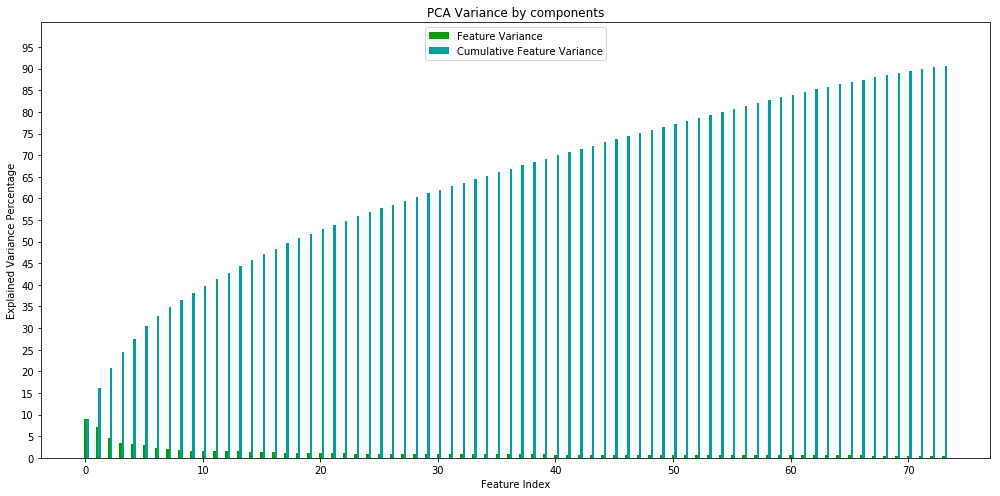

In [40]:
# Investigate the variance accounted for by each principal component.

def plot_pca_variance(variance,n_comp):
    plt.figure(figsize=(14,7))
    plt.title("PCA Variance by components")
    plt.bar(np.arange(n_comp),variance*100, width=.2, color = '#00A000', label="Feature Variance")
    plt.bar(np.arange(n_comp)+.2,np.cumsum(variance*100), width=.2, color= '#00A0A0', label="Cumulative Feature Variance")
    plt.ylabel("Explained Variance Percentage")
    plt.xlabel("Feature Index")
    plt.yticks(np.arange(0,100,5))
    plt.ylim(0,(variance.sum()*100+10))
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

plot_pca_variance(variance,n_comp)

Total variance explained by selected components : 0.7987941231936532


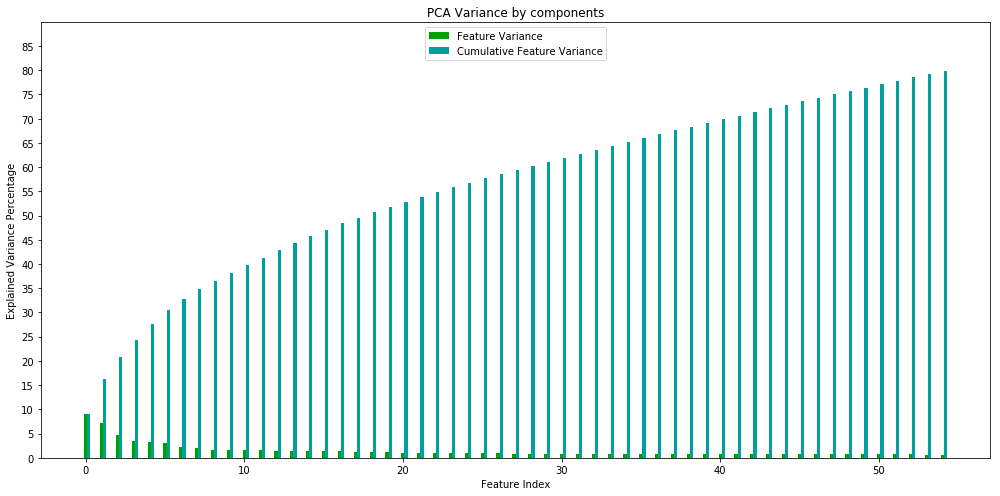

In [22]:
# Re-apply PCA to the data while selecting for number of components to retain.

def apply_pca(n_comp,df):
    pca = PCA(n_components=n_comp)
    pca.fit(df)
    variance = pca.explained_variance_ratio_
    print("Total variance explained by selected components : {}".format(variance.sum()))
    plot_pca_variance(variance,n_comp)
    return(pca, pca.transform(df))

pca_azdias, X_azdias = apply_pca(55,azdias_scaled)

#### Observations and choices: Perform Dimensionality Reduction

* Keeping the number of components to half of the total features explains 88% of the variance
* I chose to keep 55 principal components
* The reason was that I wanted to have at least 75% of the total variance explained by the components
* No single component explains more than 10% of the variance

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I will map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. I will use the data dictionary document to understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I wll investigate and interpret feature associations from the first three principal components in this substep.

In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_dim_feat_map(dimension,pca,df):
    return(pd.DataFrame(pca.components_[dimension-1:dimension]*100,columns = df.columns,\
                        index = np.arange(dimension,dimension+1,1)).sort_values(by=dimension,axis=1,ascending=False))

pca_dim_feat_map(1,pca_azdias,azdias_scaled)

,PLZ8_ANTG3,WEALTH,PLZ8_ANTG4,FINANZ_SPARER,EWDICHTE,HH_EINKOMMEN_SCORE,ORTSGR_KLS9,LP_STATUS_FEIN_2.0,FINANZ_HAUSBAUER,PLZ8_ANTG2,...,FINANZ_VORSORGER,INNENSTADT,ALTERSKATEGORIE_GROB,PLZ8_GBZ,KONSUMNAEHE,KBA05_GBZ,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO,FINANZ_MINIMALIST
1,19.066506,18.518516,16.558953,16.55459,16.471335,16.413862,16.012262,13.76093,13.611269,13.223291,...,-12.946528,-13.067309,-13.347839,-13.927123,-14.381718,-18.326509,-18.761559,-18.930588,-19.453136,-21.297597


In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_dim_feat_map(2,pca_azdias,azdias_scaled)

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,RETOURTYP_BK_S,SEMIO_LUST,FINANZ_HAUSBAUER,W_KEIT_KIND_HH,PLZ8_ANTG4,PLZ8_ANTG3,...,SEMIO_KULT,SEMIO_RAT,ONLINE_AFFINITAET,SEMIO_PFLICHT,SEMIO_TRADV,FINANZ_ANLEGER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,DECADE
2,21.59895,20.693527,18.693837,17.349328,15.352895,15.284395,12.887866,12.434481,11.607409,11.543604,...,-15.470501,-15.530825,-17.028565,-19.104103,-19.580906,-19.611198,-19.945332,-20.371436,-20.488397,-21.678316


In [25]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_dim_feat_map(3,pca_azdias,azdias_scaled)

,SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT,SEMIO_FAM,FINANZTYP_5,FINANZ_MINIMALIST,SEMIO_MAT,SEMIO_REL,SHOPPER_TYP_1.0,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_nan,SHOPPER_TYP_nan,NATIONALITAET_KZ_nan,SEMIO_RAT,FINANZ_ANLEGER,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
3,33.154709,27.398656,26.950075,24.202172,13.317141,10.882831,9.012031,8.467149,8.127656,7.398679,...,-8.42474,-11.126705,-11.202185,-14.277607,-15.950462,-19.799451,-28.493201,-29.107222,-32.431115,-33.718146


#### Observations: Interpret Principal Components

Below dimensions contain information related to the high weighted features and do not contain much information about the negatively weighted features. 

* Dimension 1:
    - High weights: Number of family houses in PLZ8 region (6-10+), estimated house hold net income, wealth, size of community

    - Negative weights: Financial habits, movement patterns, number of family houses (1-3), number of buildings in the microcell, number of houses in the microcell (1-2)
    
* Dimension 2: 
    - High weights: Age, financial preparedness, fairly supplied energy consumer, event oriented and sensual minded personality

    - Negative weights: Decade, money saver, inconspicuous spender, religiosity
    
* Dimension 3: 
    - High weights: Dreamful, family mindedness, social mindedness, cultural mindedness

    - Negative weights: Gender, combativeness, dominance, critical, rationality
    
Note - High weight does not mean that that dimension shows high value of that feature, it just means that the dimension contains more information about that feature than other features. And vice-versa for the negatively weighted features

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- I will use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data
- Then, compute the average difference from each point to its assigned cluster's center
- Perform the above two steps for a number of different cluster counts to see how the average distance decreases with an increasing number of clusters
- Once I have selected a final number of clusters to use, I will re-fit a KMeans instance to perform the clustering operation

In [26]:

# Over a number of different cluster counts...

kmeans_score = []
for n in np.arange(10,30,5):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_azdias)
    kmeans_score.append(kmeans.score(X_azdias))
    
kmeans_score

[-67502092.870533839,
 -62698567.074788794,
 -60059472.860066079,
 -57717330.982081242]

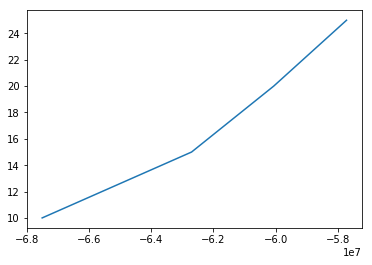

In [27]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

clusters = np.arange(10,30,5)
kmeans_score
plt.plot(kmeans_score,clusters)

In [28]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

def do_kmeans(n,X):
    kmeans = KMeans(n_clusters=n)
    kmeans_fit = kmeans.fit(X)
    kmeans_pred = kmeans.predict(X)
    kmeans_score = kmeans.score(X)
    return(kmeans_fit,kmeans_pred,kmeans_score)
    
kmeans_fit_azdias,kmeans_pred_azdias,kmeans_score_azdias  = do_kmeans(15,X_azdias)

In [29]:
kmeans_score_azdias

-63022812.00907962

#### Summary: Apply Clustering to General Population

* Numbers of clusters fit, 10,15,20,25
* The lowest average within-cluster distance is at 25 clusters
* Beyond 15 clusters, the rate of change in the average within-cluster slows down
* Hence, I use 15 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. This is NOT re-fitting all of the models to the customer data. Instead, I am going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step, I will interpret how the general population fits apply to the customer data.

In [39]:
# Check the structure of the data after it's loaded

print("Shape of the demographics data file for the customer population: {}".format(customers.shape))
nrow, ncol = customers.shape

print("\nPrint a sample of the data file")
customers.head(5)

Shape of the demographics data file for the customer population: (191652, 84)

Print a sample of the data file


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [31]:
# Need to remove 'GEBAEUDETYP' because it has different number of unique values in demographic data
# and the customer data causing one hot encoding to create different no of columns
customers = customers.drop(labels = 'GEBAEUDETYP',axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Feature: ANREDE_KZ , Unique values: [1 2]
Feature: CJT_GESAMTTYP , Unique values: [  5.   2.   6.   4.   1.   3.  nan]
Feature: FINANZTYP , Unique values: [2 6 5 3 1 4]
Feature: GFK_URLAUBERTYP , Unique values: [  4.   3.  10.   2.  11.   8.   1.   5.   9.  12.   7.   6.  nan]
Feature: GREEN_AVANTGARDE , Unique values: [1 0]
Feature: LP_FAMILIE_FEIN , Unique values: [  2.   1.  nan  10.   8.   6.  11.   9.   7.   5.   3.   4.]
Feature: LP_FAMILIE_GROB , Unique values: [  2.   1.  nan   5.   4.   3.]
Feature: LP_STATUS_FEIN , Unique values: [ 10.   9.   1.   7.   6.   3.   8.   5.   4.   2.  nan]
Feature: LP_STATUS_GROB , Unique values: [  5.   4.   1.   3.   2.  nan]
Feature: NATIONALITAET_KZ , Unique values: [  1.   2.  nan   3.]
Feature: SHOPPER_TYP , Unique values: [  3.   1.   0.   2.  nan]
Feature: SOHO_KZ , Unique values: [  0.   1.  nan]
Feature: VERS_TYP , Unique values: [  1.   2.  nan]
Feature: ZABEOTYP , Unique values: [3 1 2 4 6 5]
Feature: OST_WEST_KZ , Unique values: ['W'

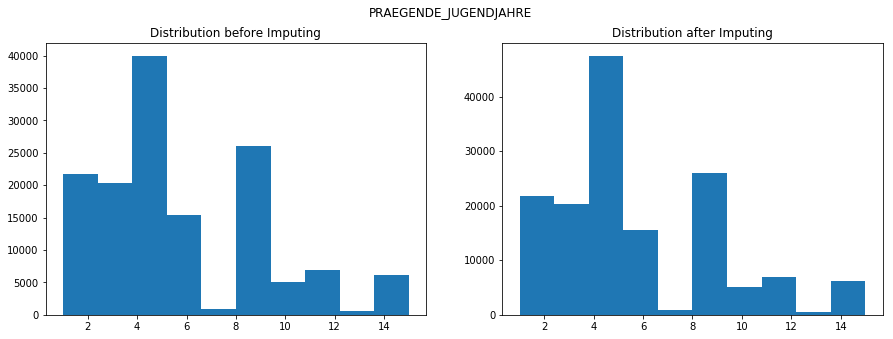

Percentage of missing values in CAMEO_INTL_2015:
6.30569611007


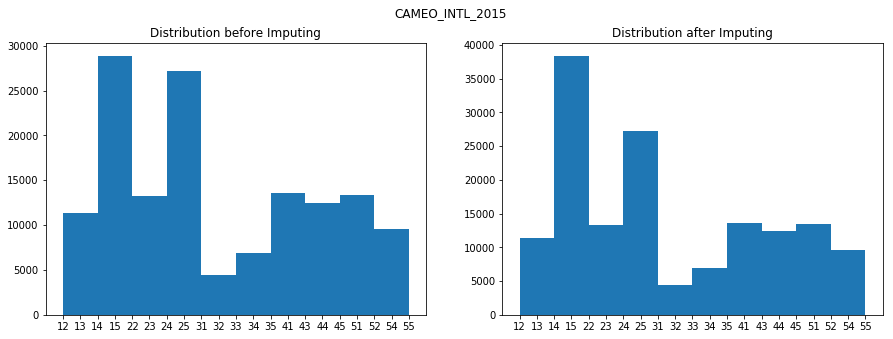

Percentage of missing values in PLZ8_BAUMAX:
7.7732180565


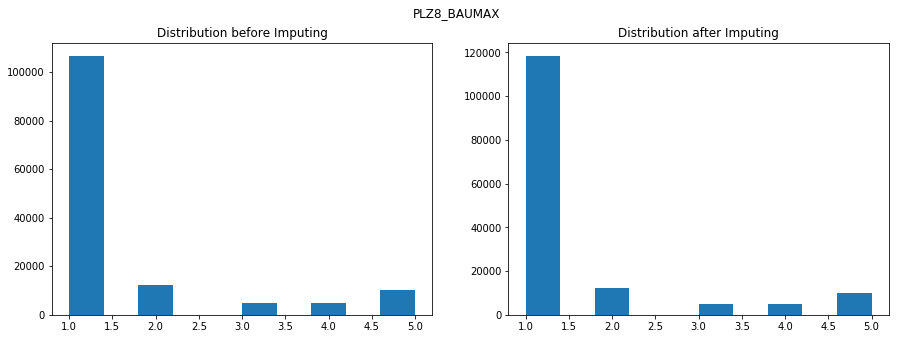


Shape of the dataframe: (150594, 141)


In [32]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_encoded = clean_data(customers,feat_info)
customers_scaled = scaler_azdias.transform(customers_encoded)
X_customers = pca_azdias.transform(customers_scaled)
kmeans_pred_customers = kmeans_fit_azdias.predict(X_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cluster_prop = pd.DataFrame(columns={'General','Customers'},index=np.arange(0,15))

for i in range(15):
    cluster_prop['General'][i] = (kmeans_pred_azdias==i).sum()*100/len(kmeans_pred_azdias)
    cluster_prop['Customers'][i] = (kmeans_pred_customers==i).sum()*100/len(kmeans_pred_customers)

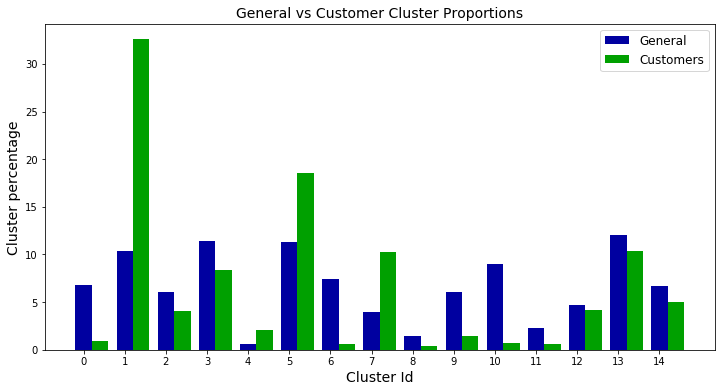

In [34]:
plt.figure(figsize=(12,6))
plt.title('General vs Customer Cluster Proportions', fontsize=14)
plt.bar(x=np.arange(0,15),height=cluster_prop['General'],width=.4,color='#0000A0',label='General')
plt.bar(x=np.arange(0,15)+.4,height=cluster_prop['Customers'],width=.4,color='#00A000',label='Customers')
plt.ylabel('Cluster percentage',fontsize=14)
plt.xlabel('Cluster Id',fontsize=14)
plt.xticks(np.arange(0,15,1))
plt.legend(fontsize=12)

In [41]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Get inverse PCA transform for general population
inv_pca_azdias = pca_azdias.inverse_transform(X_azdias)
all_clusters_azdias = pd.DataFrame(inv_pca_azdias, index=np.arange(0,len(inv_pca_azdias)), columns=azdias_encoded.columns)

# Function to get pre-PCA data for a given cluster
def cluster_data(pca,X,kmeans_pred,cluster_id,data_encoded):
    cluster_data = pca.inverse_transform(X[np.where(kmeans_pred==cluster_id)])
    cluster_df = pd.DataFrame(cluster_data, index=np.arange(0,len(cluster_data)), columns=data_encoded.columns)
    return(cluster_df)

cluster_1_azdias = cluster_data(pca_azdias,X_azdias,kmeans_pred_azdias,1,azdias_encoded)

In [42]:
# Ratio of feature median between the given cluster and the all data
cluster_1_azdias_high_median = (cluster_1_azdias.median()/all_clusters_azdias.median()).reset_index().sort_values([0],ascending=False)

# Top 10 features having high values in the given cluster as compared to all data
cluster_1_azdias_high_median.head(10)

,index,0
82,FINANZ_MINIMALIST,82.327762
85,FINANZ_ANLEGER,71.269136
95,SEMIO_LUST,44.750736
118,MOBI_REGIO,39.697456
107,KONSUMNAEHE,31.809685
121,PLZ8_ANTG1,26.527406
75,DECADE,22.063080
98,SEMIO_RAT,14.124394
112,KBA05_GBZ,12.043488
84,FINANZ_VORSORGER,11.762230


In [43]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Get pre-PCA data for a given cluster
cluster_10_azdias = cluster_data(pca_azdias,X_azdias,kmeans_pred_azdias,10,azdias_encoded)

# Ratio of feature median between the given cluster and the all data
cluster_10_azdias_high_median = (cluster_10_azdias.median()/all_clusters_azdias.median()).reset_index().sort_values([0],ascending=False)

# Top 10 features having high values in the given cluster as compared to all data
cluster_10_azdias_high_median.head(10)

,index,0
123,PLZ8_ANTG3,42.279166
122,PLZ8_ANTG2,36.544205
87,FINANZ_HAUSBAUER,16.659527
114,EWDICHTE,10.686682
109,KBA05_ANTG2,7.686604
108,KBA05_ANTG1,7.680508
104,HH_EINKOMMEN_SCORE,6.660521
100,SEMIO_DOM,6.153652
77,WEALTH,4.657026
126,PLZ8_GBZ,4.337232


#### Summary: Compare Customer Data to Demographics Data

Plotting the proportion of cluster population/all population for both general and customer data set shows that cluster 1 is overrepresented in customers and cluster 10 is underrepresented in customers

* Overrepresented Cluster: Calculating the proportion of median values for each feature for cluster 1/all clusters for general population, and sorting the results brings out a few features which had high values in cluster 1 
    - FINANZ_MINIMALIST/ANLEGER/VORSORGER: People with very low financial interest, investments or preparedness
    - SEMIO_LUST/RAT: Personalities with low affinity to sensual mindedness or rationality
    - MOBI_REGIO: Low movements patterns
    - DECADE: Youth decades in the 80's and 90's
    - KBA05_GBZ: More number of buildings in the microcell
    
    
* Underrepresented Cluster: Calculating the proportion of median values for each feature for cluster 10/all clusters for general population, and sorting the results brings out a few features which had high values in cluster 10 
    - FINANZ_HAUSBAUER: Low rate of home ownership
    - PLZ8_ANTG3/4/PLZ8_GBZ: High share of 3-10 family houses in PLZ8 region, more buildings in the PLZ8 region
    - EWDICHTE: High density of households per square km
    - KBA05_ANTG2/3: High share of 3-10 family houses in the microcell
    - HH_EINKOMMEN_SCORE/WEALTH: Low estimated household income, poorer households
    - SEMIO_DOM: Personalities with low affinity to dominant mindedness